In [ ]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 0 1 2 1 0 2 1 0 1 0 2 0 0 0 2 0 2 0 0 2 1 0 2 0 2 1 2]


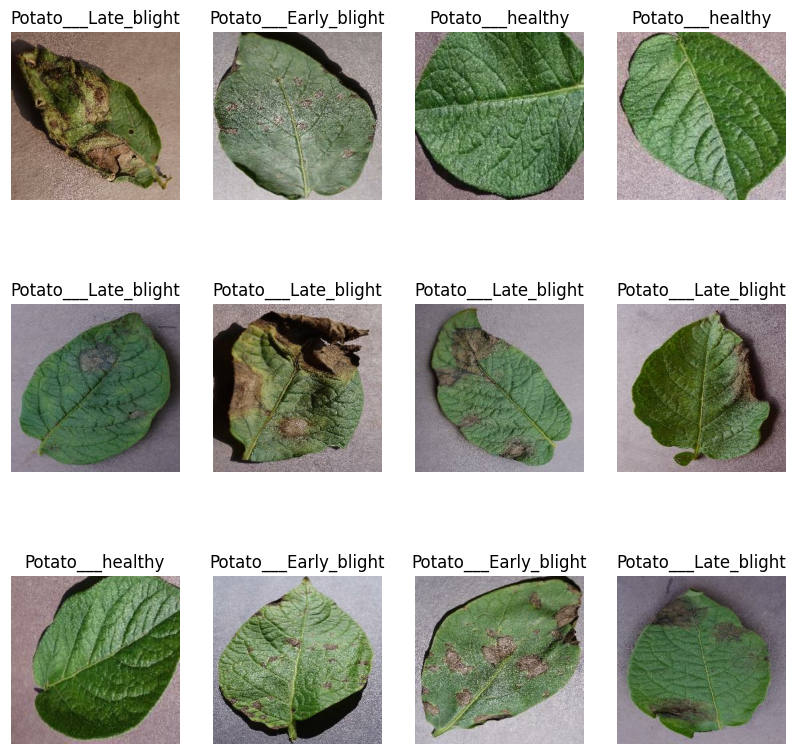

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

94

In [ ]:
train_size = 0.8
len(dataset)*train_size

75.2

In [ ]:
train_ds = dataset.take(75)
len(train_ds)

75

In [ ]:
test_ds = dataset.skip(75)
len(test_ds)

19

In [ ]:
val_size=0.1
len(dataset)*val_size

9.4

In [ ]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [ ]:
test_ds = test_ds.skip(9)
len(test_ds)

10

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  75
Validation Dataset Size:  9
Test Dataset Size:  10


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
75/75 [==============================] - 23s 198ms/step - loss: 1.8125 - accuracy: 0.4544 - val_loss: 0.9116 - val_accuracy: 0.6771
Epoch 2/50
75/75 [==============================] - 10s 138ms/step - loss: 0.9422 - accuracy: 0.6547 - val_loss: 0.8220 - val_accuracy: 0.6458
Epoch 3/50
75/75 [==============================] - 10s 136ms/step - loss: 0.7344 - accuracy: 0.7224 - val_loss: 0.8633 - val_accuracy: 0.6562
Epoch 4/50
75/75 [==============================] - 10s 137ms/step - loss: 0.6198 - accuracy: 0.7613 - val_loss: 0.4431 - val_accuracy: 0.8646
Epoch 5/50
75/75 [==============================] - 10s 138ms/step - loss: 0.5090 - accuracy: 0.8131 - val_loss: 0.3921 - val_accuracy: 0.8507
Epoch 6/50
75/75 [==============================] - 10s 137ms/step - loss: 0.4761 - accuracy: 0.8340 - val_loss: 0.4391 - val_accuracy: 0.8299
Epoch 7/50
75/75 [==============================] - 11s 140ms/step - loss: 0.4137 - accuracy: 0.8562 - val_loss: 0.2820 - val_accuracy: 0.9167

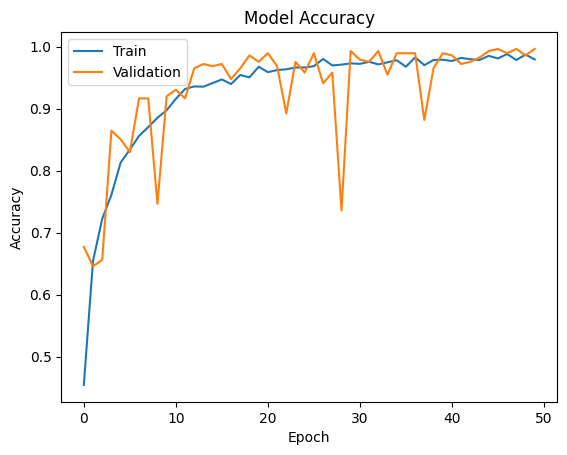

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

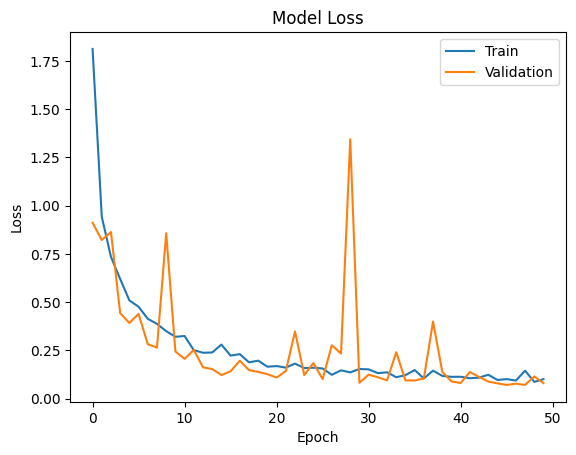

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

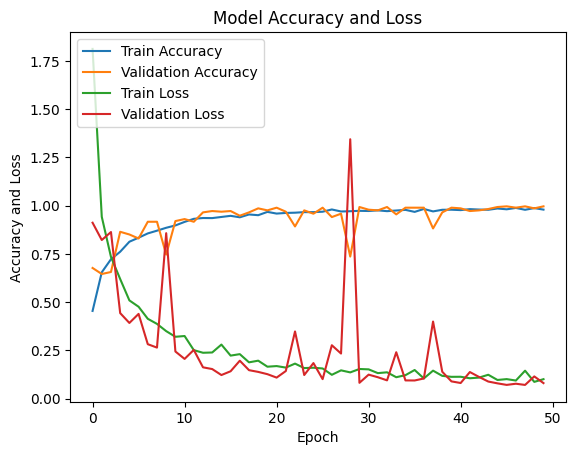

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

10/10 [==============================] - 3s 47ms/step - loss: 0.0599 - accuracy: 0.9906


[0.4544314444065094,
 0.6546822786331177,
 0.7224080562591553,
 0.7612876296043396,
 0.8131271004676819,
 0.8340300917625427,
 0.8561872839927673,
 0.8704013228416443,
 0.8854514956474304,
 0.8975752592086792,
 0.9159699082374573,
 0.9318562150001526,
 0.9360367655754089,
 0.9356187582015991,
 0.9414715766906738,
 0.9473243951797485,
 0.9397993087768555,
 0.954431414604187,
 0.9506688714027405,
 0.9678093791007996,
 0.9590300917625427,
 0.9623745679855347,
 0.9636287689208984,
 0.9665551781654358,
 0.9665551781654358,
 0.9686455130577087,
 0.9803511500358582,
 0.9698996543884277,
 0.9711538553237915,
 0.9732441306114197,
 0.9724080562591553,
 0.9757525324821472,
 0.9715719223022461,
 0.974916398525238,
 0.97826087474823,
 0.9678093791007996,
 0.9828595519065857,
 0.9703177213668823,
 0.9786789417266846,
 0.9790970087051392,
 0.9770066738128662,
 0.9820234179496765,
 0.9799330830574036,
 0.9786789417266846,
 0.9853678941726685,
 0.9811872839927673,
 0.9882943034172058,
 0.97867894172668

In [ ]:
history.history['val_accuracy']

[0.6770833134651184,
 0.6458333134651184,
 0.65625,
 0.8645833134651184,
 0.8506944179534912,
 0.8298611044883728,
 0.9166666865348816,
 0.9166666865348816,
 0.7465277910232544,
 0.9201388955116272,
 0.9305555820465088,
 0.9166666865348816,
 0.9652777910232544,
 0.9722222089767456,
 0.96875,
 0.9722222089767456,
 0.9479166865348816,
 0.9652777910232544,
 0.9861111044883728,
 0.9756944179534912,
 0.9895833134651184,
 0.96875,
 0.8923611044883728,
 0.9756944179534912,
 0.9583333134651184,
 0.9895833134651184,
 0.9409722089767456,
 0.9583333134651184,
 0.7361111044883728,
 0.9930555820465088,
 0.9791666865348816,
 0.9756944179534912,
 0.9930555820465088,
 0.9548611044883728,
 0.9895833134651184,
 0.9895833134651184,
 0.9895833134651184,
 0.8819444179534912,
 0.9652777910232544,
 0.9895833134651184,
 0.9861111044883728,
 0.9722222089767456,
 0.9756944179534912,
 0.9826388955116272,
 0.9930555820465088,
 0.9965277910232544,
 0.9895833134651184,
 0.9965277910232544,
 0.9861111044883728,
 0.9

In [ ]:
history.history['loss']

[1.8125280141830444,
 0.9422144293785095,
 0.7343621850013733,
 0.6197911500930786,
 0.5089938044548035,
 0.47609418630599976,
 0.41365131735801697,
 0.387274831533432,
 0.3496927320957184,
 0.32045117020606995,
 0.3243628144264221,
 0.251181960105896,
 0.23756705224514008,
 0.23903456330299377,
 0.27998799085617065,
 0.22281302511692047,
 0.23042139410972595,
 0.18794310092926025,
 0.19655610620975494,
 0.16535016894340515,
 0.16858792304992676,
 0.1606946438550949,
 0.1813669055700302,
 0.15816114842891693,
 0.16005627810955048,
 0.15613995492458344,
 0.12329632043838501,
 0.1463993489742279,
 0.1358378678560257,
 0.15341705083847046,
 0.15158309042453766,
 0.1320582926273346,
 0.13627409934997559,
 0.1107836440205574,
 0.1214626133441925,
 0.1481972485780716,
 0.10455560684204102,
 0.1448555737733841,
 0.11781463772058487,
 0.11281795054674149,
 0.11314546316862106,
 0.10539518296718597,
 0.10890691727399826,
 0.12353123724460602,
 0.0965389683842659,
 0.10100473463535309,
 0.093590

In [ ]:
history.history['val_loss']

[0.9116300940513611,
 0.8220208287239075,
 0.863324761390686,
 0.4431363642215729,
 0.39209476113319397,
 0.43906843662261963,
 0.28198131918907166,
 0.2643360495567322,
 0.8574347496032715,
 0.24413970112800598,
 0.2057299017906189,
 0.2523403763771057,
 0.16210241615772247,
 0.15310198068618774,
 0.12212587893009186,
 0.14167548716068268,
 0.19637656211853027,
 0.14732792973518372,
 0.1383812129497528,
 0.12655919790267944,
 0.10883340239524841,
 0.1428932100534439,
 0.34806856513023376,
 0.12221230566501617,
 0.18406206369400024,
 0.1008678674697876,
 0.27659767866134644,
 0.23349520564079285,
 1.344346046447754,
 0.0818111002445221,
 0.12415646016597748,
 0.11075714975595474,
 0.09457502514123917,
 0.2403615564107895,
 0.09425833821296692,
 0.0939047560095787,
 0.10421661287546158,
 0.39951562881469727,
 0.1390634924173355,
 0.08919166773557663,
 0.08077902346849442,
 0.1376119703054428,
 0.11218375712633133,
 0.08837733417749405,
 0.07901917397975922,
 0.071014903485775,
 0.077097

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.9906250238418579
Loss:  0.059896402060985565


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

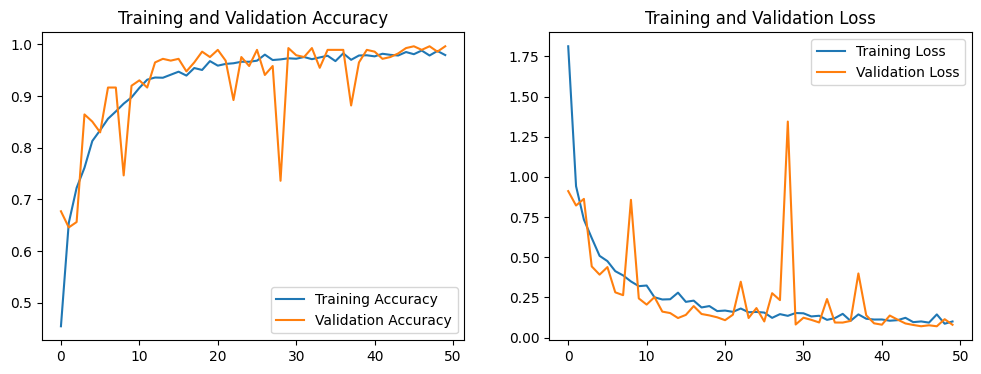

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Late_blight
1/1 [==============================] - 0s 199ms/step
[2.5124493e-06 9.9999738e-01 1.6856360e-07]
Max Value: 1
Predicted Label: Potato___Late_blight


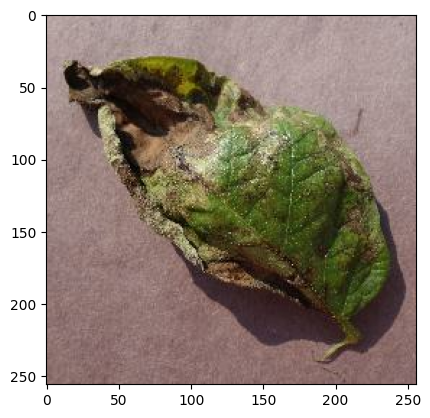

In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


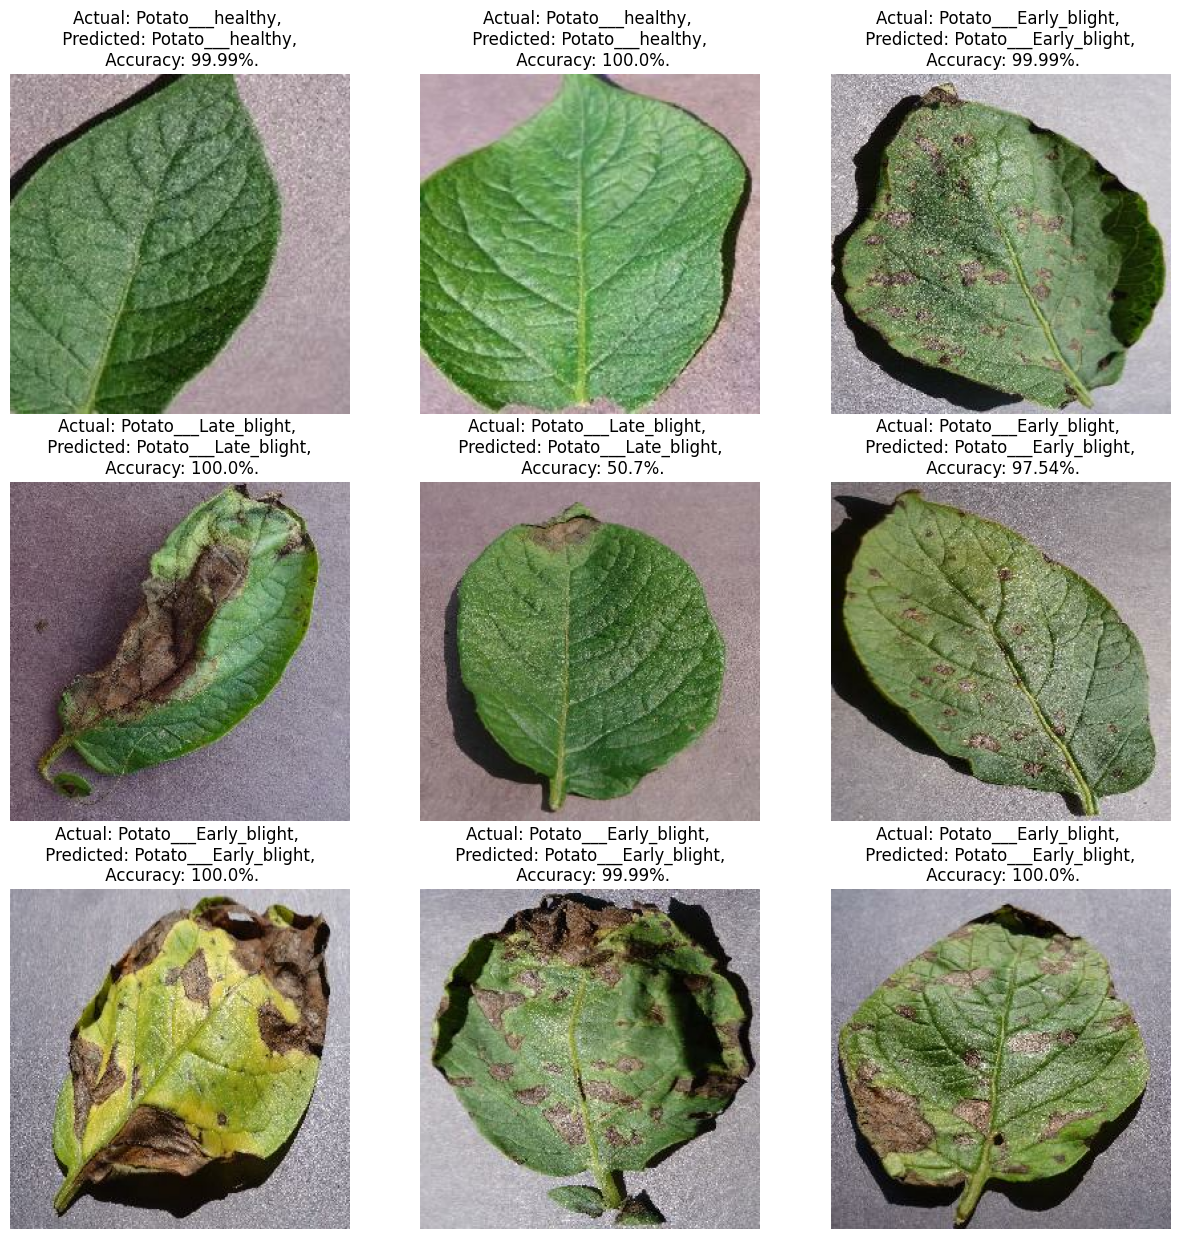

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [ ]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  99.06250238418579


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

10/10 [==============================] - 0s 39ms/step
F1 Score:  30.012429458586958
Precision Score:  30.025672281323878
Recall Score:  30.0


10/10 [==============================] - 0s 36ms/step


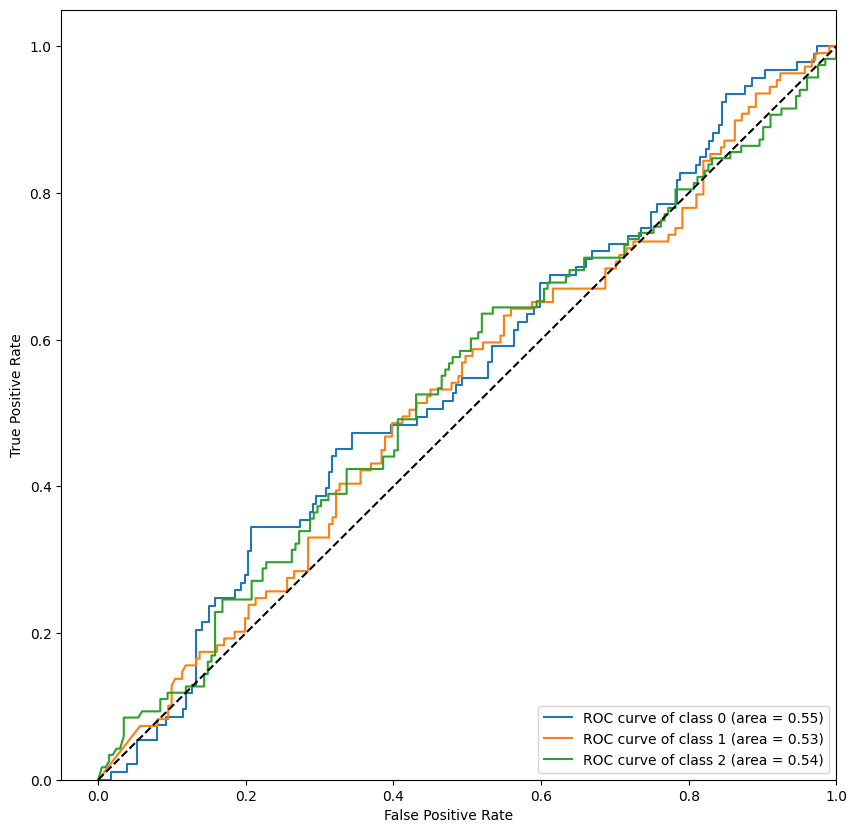

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

10/10 [==============================] - 0s 34ms/step


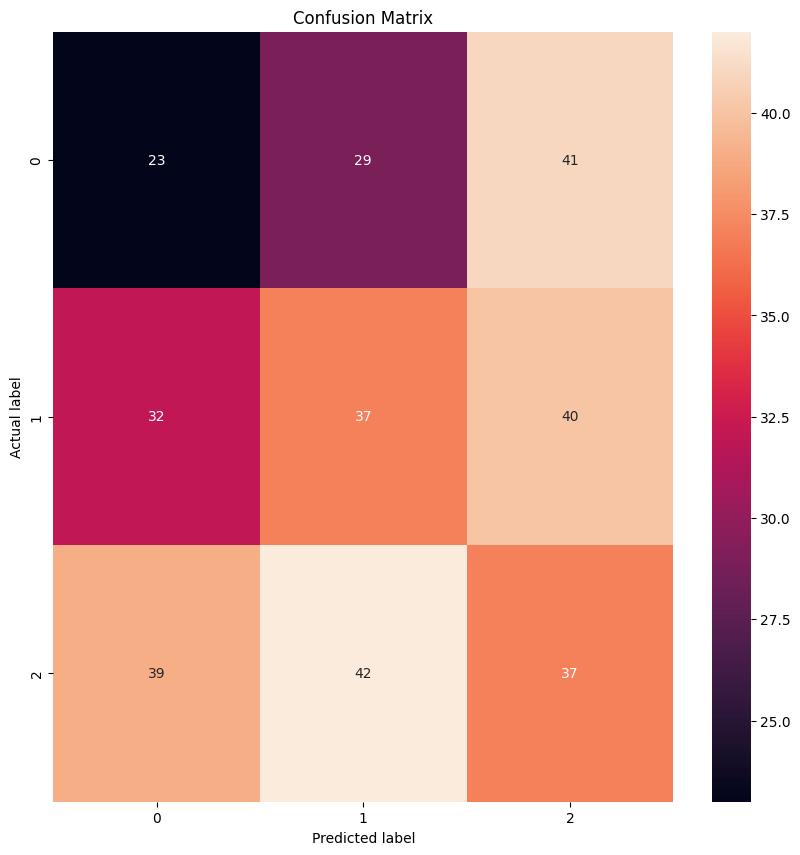

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()